##  Explore data and perform data transformantion
* remove size information 
* aggregate stock and promo_counts by mean function 
* cast type 

In [1]:
import pandas as pd 
import os 


root_dir = './'
sales_file = 'demands.csv'
item_file = 'item_meta.csv'
rts_file = 'related_ts.csv'



sales = pd.read_csv(os.path.join(root_dir, sales_file))
sales

,item_id,timestamp,demand,store_id,state_id
0,FOODS_1_001,2011-01-29,3,CA_1,CA
1,FOODS_1_002,2011-01-29,0,CA_1,CA
2,FOODS_1_003,2011-01-29,0,CA_1,CA
3,FOODS_1_004,2011-01-29,0,CA_1,CA
4,FOODS_1_005,2011-01-29,3,CA_1,CA
...,...,...,...,...,...
5738995,FOODS_2_080,2016-04-24,0,WI_3,WI
5738996,FOODS_2_081,2016-04-24,3,WI_3,WI
5738997,FOODS_2_082,2016-04-24,1,WI_3,WI
5738998,FOODS_2_083,2016-04-24,1,WI_3,WI


#### can replace 0 demands to null 
[best practice of preparing data](https://aws.amazon.com/blogs/machine-learning/tailor-and-prepare-your-data-for-amazon-forecast/)

```
processed_sales = sales.copy()
processed_sales['demand'] = sales['demand'].apply(lambda x: None if x==0 else 0)
processed_sales.to_csv('processed_demands.csv', index=False)
processed_sales
```

In [2]:
processed_sales = sales.copy()
processed_sales = processed_sales[processed_sales['demand']>0]
processed_sales.to_csv('processed_demands.csv', index=False)
processed_sales

,item_id,timestamp,demand,store_id,state_id
0,FOODS_1_001,2011-01-29,3,CA_1,CA
4,FOODS_1_005,2011-01-29,3,CA_1,CA
9,FOODS_1_011,2011-01-29,2,CA_1,CA
11,FOODS_1_013,2011-01-29,2,CA_1,CA
14,FOODS_1_016,2011-01-29,4,CA_1,CA
...,...,...,...,...,...
5738993,FOODS_2_078,2016-04-24,3,WI_3,WI
5738996,FOODS_2_081,2016-04-24,3,WI_3,WI
5738997,FOODS_2_082,2016-04-24,1,WI_3,WI
5738998,FOODS_2_083,2016-04-24,1,WI_3,WI


In [3]:
meta_df = pd.read_csv(os.path.join(root_dir, item_file))

meta_df

,item_id,dept_id,cat_id
0,FOODS_1_001,FOODS_1,FOODS
1,FOODS_1_002,FOODS_1,FOODS
2,FOODS_1_003,FOODS_1,FOODS
3,FOODS_1_004,FOODS_1,FOODS
4,FOODS_1_005,FOODS_1,FOODS
...,...,...,...
295,FOODS_2_080,FOODS_2,FOODS
296,FOODS_2_081,FOODS_2,FOODS
297,FOODS_2_082,FOODS_2,FOODS
298,FOODS_2_083,FOODS_2,FOODS


In [4]:
related_ts = pd.read_csv(os.path.join(root_dir, rts_file))

### Observe data distribution 
* Data is highly skewed 


In [5]:
demand_by_item = sales.groupby(['item_id', 'timestamp']).sum().reset_index()

In [6]:


demand_by_item.groupby(['item_id']).sum().reset_index().merge(meta_df, left_on=['item_id'], right_on=['item_id']).sort_values(by=['demand'], ascending=False)


,item_id,demand,dept_id,cat_id
214,FOODS_1_218,234594,FOODS_1,FOODS
83,FOODS_1_085,148487,FOODS_1,FOODS
16,FOODS_1_018,133105,FOODS_1,FOODS
3,FOODS_1_004,129481,FOODS_1,FOODS
41,FOODS_1_043,128933,FOODS_1,FOODS
...,...,...,...,...
82,FOODS_1_084,2047,FOODS_1,FOODS
157,FOODS_1_160,1998,FOODS_1,FOODS
77,FOODS_1_079,1681,FOODS_1,FOODS
286,FOODS_2_071,1123,FOODS_2,FOODS


<AxesSubplot:ylabel='Frequency'>

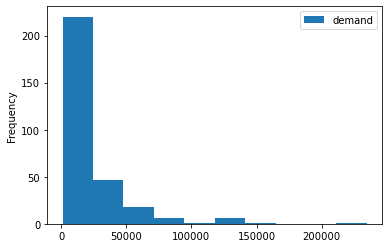

In [7]:
demand_by_item.groupby(['item_id']).sum().plot.hist(bins=10)

<AxesSubplot:xlabel='item_id'>

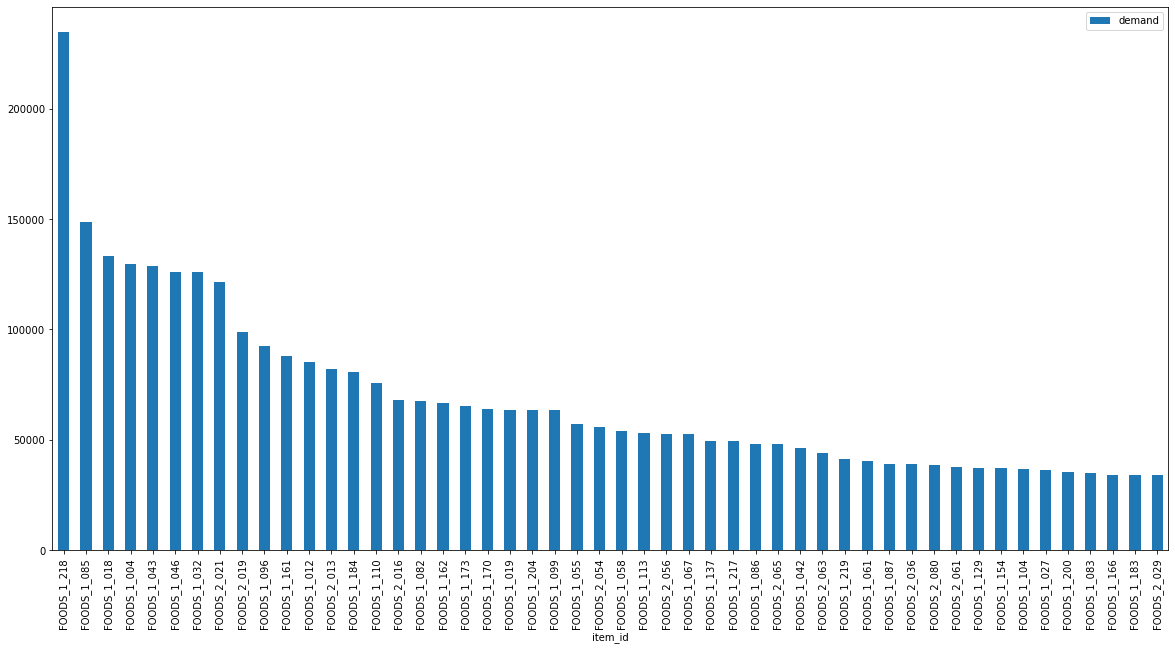

In [8]:
item_code_demand = sales.groupby(['item_id']).sum().reset_index()
item_code_demand = item_code_demand.sort_values(by=['demand'], ascending=False)

item_code_demand[:50].plot.bar(x='item_id', y='demand', figsize=(20, 10)) 


### Add aggregated metrics - proved to be effective in current results 

In [9]:
len(sales)

5739000

In [10]:
aggregated_metrics = sales.sort_values(by=['item_id',  'store_id', 'state_id', 'timestamp'])

In [11]:
def agg_demands(data_df): 
    data_df['rolling_mean_t1'] = data_df.groupby(['item_id','store_id', 'state_id'])['demand'].transform(lambda x: x.shift(60).rolling(7).mean())
    data_df['rolling_std_t1'] = data_df.groupby(['item_id', 'store_id', 'state_id'])['demand'].transform(lambda x: x.shift(60).rolling(7).std())
    data_df['rolling_mean_t2'] = data_df.groupby(['item_id','store_id', 'state_id'])['demand'].transform(lambda x: x.shift(60).rolling(14).mean())
    data_df['rolling_std_t2'] = data_df.groupby(['item_id', 'store_id', 'state_id'])['demand'].transform(lambda x: x.shift(60).rolling(14).std())
    data_df['rolling_mean_t4'] = data_df.groupby(['item_id','store_id', 'state_id'])['demand'].transform(lambda x: x.shift(60).rolling(30).mean())
    data_df['rolling_std_t4'] = data_df.groupby(['item_id', 'store_id', 'state_id'])['demand'].transform(lambda x: x.shift(60).rolling(30).std())
    data_df['rolling_mean_t12'] = data_df.groupby(['item_id', 'store_id', 'state_id'])['demand'].transform(lambda x: x.shift(60).rolling(90).mean())
    data_df['rolling_mean_t24'] = data_df.groupby(['item_id', 'store_id', 'state_id'])['demand'].transform(lambda x: x.shift(60).rolling(180).mean())

agg_demands(aggregated_metrics) 
                                                                                               

KeyboardInterrupt: 

In [ ]:
def price_aug(data): 
    data['lag_price_t1'] = data.groupby(['item_id','store_id', 'state_id'])['sell_price'].transform(lambda x: x.shift(1))
    data['price_change_t1'] = (data['lag_price_t1'] - data['sell_price']) / (data['lag_price_t1'])
    data['rolling_price_max_t365'] = data.groupby(['item_id','store_id', 'state_id'])['sell_price'].transform(lambda x: x.shift(1).rolling(365).max())
    data['price_change_t365'] = (data['rolling_price_max_t365'] - data['sell_price']) / (data['rolling_price_max_t365'])
    data['rolling_price_std_t7'] = data.groupby(['item_id','store_id', 'state_id'])['sell_price'].transform(lambda x: x.rolling(7).std())
    data['rolling_price_std_t30'] = data.groupby(['item_id','store_id', 'state_id'])['sell_price'].transform(lambda x: x.rolling(30).std())
    data.drop(['rolling_price_max_t365', 'lag_price_t1'], inplace = True, axis = 1)
    
price_aug(related_ts)     

In [ ]:

related_ts_aug_df = aggregated_metrics[['timestamp','item_id','store_id', 'state_id', 'rolling_mean_t1',  'rolling_mean_t2', 'rolling_mean_t4',  'rolling_mean_t12', 'rolling_mean_t24']]


In [ ]:
related_ts = related_ts.merge(related_ts_aug_df, on=['item_id', 'timestamp', 'store_id', 'state_id'])

In [ ]:
len(related_ts_aug_df) 

In [ ]:
related_ts = related_ts.fillna(0)
related_ts.to_csv('flattened_rts_agg_metrics.csv', index=False)

In [ ]:
related_ts_aug_df

### Preparing clustering data - not included in the first phase 

In [ ]:
items = sales[['item_id']].drop_duplicates()
items

In [ ]:
store_ids = sales[['store_id']].drop_duplicates()
store_ids

In [ ]:
import math 
import random 
vec_index = {} 
vectors = [] 
rows = [] 
j = 0 

sampled_items = items['item_id'].values
random.shuffle(sampled_items)


for item_id in sampled_items[:300]: 
    for store_id in ['CA_1', 'TX_1', 'WI_1']:
        cur_vec = sales[(sales['item_id']==item_id) & (sales['store_id']==store_id)] 
        vec = cur_vec.sort_values(by=['timestamp']).fillna(0.0)['demand'].tolist()[:360]
        vectors.append(vec)
        vec_index[(item_id, store_id)] = j
        j += 1 



In [ ]:
import numpy as np 

vectors = np.array(vectors)

In [ ]:
!pip install tslearn

In [ ]:
from tslearn.utils import to_time_series_dataset
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tslearn.clustering import TimeSeriesKMeans, silhouette_score

In [ ]:

# normalize time series to zero mean and unit variance
X_train = TimeSeriesScalerMeanVariance().fit_transform(vectors)
# X_train = np.array([vectors])
print(X_train.shape)

In [ ]:
np.array([vectors])

In [ ]:
import os
# create required directory structure
!rm -rf tsl
dir_paths = ['./tsl', './tsl/models', './tsl/plots']

for dir_path in dir_paths:
    if not os.path.exists(dir_path):
        os.makedirs(dir_path)

In [ ]:
# algorithm configuration
algo = "DTW_kmeans"
metric = "dtw"

# cluster configuration
N_CLUSTERS = 3

model= TimeSeriesKMeans(n_clusters=N_CLUSTERS,
                        metric=metric,
                        n_jobs=-1,
                        random_state=0)

y_pred = model.fit_predict(X_train)

model.to_pickle(f"./tsl/models/{algo}.pkl")

In [ ]:
silhouette_score(X_train, y_pred, metric="dtw")


In [ ]:
np.save(f"./tls_{algo}_cluster_labels", y_pred)

In [ ]:
%%time
import matplotlib.pyplot as plt

for yi in range(N_CLUSTERS):
    X_sub = X_train[y_pred == yi]
    ts_cnt = pd.Series(y_pred[y_pred == yi]).shape[0]
    fig = plt.figure()
    plt.title(f"{algo} | Cluster ID: {yi} | TS Count: {ts_cnt}")
    for xx in X_sub:
        plt.plot(xx.ravel(), color='xkcd:sky blue', alpha=0.25)
    fig.savefig(f"./tsl/plots/{algo}_cls_lbl_{yi}.png", dpi=150)
    plt.show()
    plt.close()

In [ ]:
cluster_df = sales.copy()
cluster_df

In [ ]:
cluster_pred = [] 
for index, row in cluster_df.iterrows():
    item_id = row['item_id']
    store_id = row['store_id']
    if (item_id, store_id) in vec_index:
        cluster_pred.append(y_pred[vec_index[(item_id, store_id)]])
    else:
        cluster_pred.append(-1)

    
cluster_df['cluster'] = np.array(cluster_pred)     

In [ ]:
cluster_df

In [ ]:
cluster_df

In [ ]:
cluster2_f = cluster_df[cluster_df['cluster']==2].drop(['cluster'], axis=1)[['item_id','store_id','state_id','timestamp', 'demand']]
print(cluster2_f['demand'].sum() // len(cluster2_f['item_id'].unique()))
cluster2_f.to_csv('cluster_2.csv', index=False)
cluster1_f = cluster_df[cluster_df['cluster']==1].drop(['cluster'], axis=1)[['item_id', 'store_id', 'state_id','timestamp', 'demand']]
print(cluster1_f['demand'].sum() // len(cluster1_f['item_id'].unique()))
cluster1_f.to_csv('cluster_1.csv', index=False)
cluster0_f = cluster_df[cluster_df['cluster']==0].drop(['cluster'], axis=1)[['item_id', 'store_id','state_id','timestamp', 'demand']]
print(cluster0_f['demand'].sum() // len(cluster0_f['item_id'].unique()))
cluster0_f.to_csv('cluster_0.csv', index=False)



In [ ]:
meta_df

In [ ]:
meta_df[['dept_id','cat_id']].drop_duplicates()

In [ ]:
import matplotlib.pyplot as plt

def analysis_cluster(cluster, meta, meta_id, group): 
    item_in_cluster =  set(cluster['item_id'].unique())
    meta_c = meta[meta[meta_id].isin(item_in_cluster)]
    pt = meta_c.groupby([group]).count()[meta_id]
    pt.plot.bar(subplots=True)
    

#### can try different clusters to observe 

In [ ]:
analysis_cluster(cluster0_f, meta_df, 'item_id', 'dept_id')

In [ ]:
analysis_cluster(cluster1_f, meta_df, 'item_id', 'dept_id')

In [ ]:
analysis_cluster(cluster2_f, meta_df, 'item_id', 'dept_id')